# **Sports / Politics Tweets Classification**

In [117]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

kaggle/input\deeptweets\sample_submission.csv
kaggle/input\deeptweets\test.csv
kaggle/input\deeptweets\train.csv
kaggle/input\deeptweets\training.csv


# **Importing the necessary modules**

In [118]:
import nltk
import matplotlib.pyplot as plt
import copy

# **Loading The Data**

In [119]:
train_df = pd.read_csv('kaggle/input/deeptweets/training.csv')
test_df = pd.read_csv('kaggle/input/deeptweets/test.csv')

# **First Looks on the Data**

In [120]:
train_df.head()

,TweetId,Label,TweetText
0,304271250237304833,Politics,'#SecKerry: The value of the @StateDept and @U...
1,304834304222064640,Politics,'@rraina1481 I fear so'
2,303568995880144898,Sports,'Watch video highlights of the #wwc13 final be...
3,304366580664528896,Sports,'RT @chelscanlan: At Nitro Circus at #AlbertPa...
4,296770931098009601,Sports,'@cricketfox Always a good thing. Thanks for t...


In [121]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6525 entries, 0 to 6524
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   TweetId    6525 non-null   int64 
 1   Label      6525 non-null   object
 2   TweetText  6525 non-null   object
dtypes: int64(1), object(2)
memory usage: 153.1+ KB


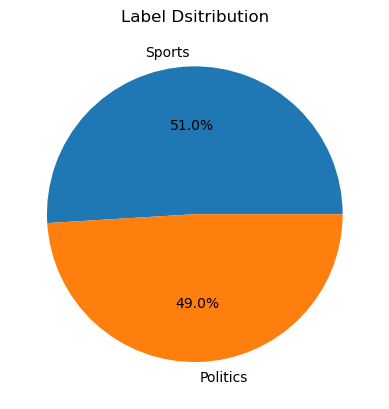

In [122]:
labels = train_df['Label']
counts = labels.value_counts()

# viziualize the counts in a pie chart
plt.pie(counts, labels=counts.index, autopct='%1.1f%%')
plt.title('Label Dsitribution')
plt.show()

Notice how the data here is almost equal in size, which will Help in giving more accurate results after the training.

In [123]:
def tweet_length(data):
    t_length = []
    cp = copy.deepcopy(data)
    for i in range(cp.shape[0]):
        t_length.append(len(cp['TweetText'][i]))
    cp['TweetLength'] = t_length
    return cp

In [124]:
train_copy= tweet_length(train_df)
test_copy = tweet_length(test_df)

In [125]:
name_dist = train_copy.groupby('Label')['TweetLength'].agg(['min','max','mean'])
name_dist

,min,max,mean
Label,,,
Politics,15,167,115.036875
Sports,5,167,105.833083


It's important for the data elements ( Tweet's text content ) to be equal in size so that the tweets so that both labels can be equaly distinguished by the ML Algorithm.

# **Preprocessing**

In [126]:
import re                                  # library for regular expression operations
import string                              # for string operations

from nltk.corpus import stopwords          # module for stop words that come with NLTK
from nltk.stem import PorterStemmer        # module for stemming
from nltk.tokenize import TweetTokenizer

In [82]:
nltk.download('wordnet')
nltk.download('stopwords')

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\ayoub\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\ayoub\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [127]:
#def preprocessing(data) :
def clean(data):
    cleaned = []
    for txt in data['TweetText']:
        # remove old style retweet text "RT"
        clean = re.sub(r'^RT[\s]+', '', txt)
        
        # remove hyperlinks
        clean= re.sub(r'https?://[^\s\n\r]+', '', clean)

        # remove hashtags
        # only removing the hash # sign from the word
        clean = re.sub(r'#', '', clean)
        cleaned.append(clean)
    data['Cleaned'] = cleaned
    
    
def tokenize(data):
    tokenized = []
    tokenizer = TweetTokenizer(preserve_case=False, strip_handles=True,reduce_len=True)
    for txt in data['Cleaned'] : 
        tweet_tokens = tokenizer.tokenize(txt)
        tokenized.append(tweet_tokens)
    data['Tokenized'] = tokenized
    
    
def removePuncuationsStopWords(data):
    stopwords_english = stopwords.words('english') 
    
    tweets = []
    for tweet in data['Tokenized']: # Go through every word in your tokens list
        preprocessed_tweet = []
        # remove stop words and punctuation
        for word in  tweet :
            if (word not in stopwords_english and  word not in string.punctuation):  
                preprocessed_tweet.append(word)
        tweets.append(preprocessed_tweet)
    data['TweetWords'] = tweets
    
    
def stemming(data):
    stemmer = PorterStemmer() 
    # Create an empty list to store the stems
    tweets = []
    for tweet in data['TweetWords']:
        word_stem = []
        for word in tweet :  
            stem_word = stemmer.stem(word) 
            word_stem.append(stem_word)  
        tweets.append(word_stem)
    data['Tweet'] = tweets
        
def preprocessing(data):
    clean(data)
    tokenize(data)
    removePuncuationsStopWords(data)
    stemming(data)
    data.drop(columns=['Cleaned','Tokenized','TweetText','TweetWords'],inplace=True) 

In [128]:
preprocessing(train_copy)
preprocessing(test_copy)
train_copy

,TweetId,Label,TweetLength,Tweet
0,304271250237304833,Politics,125,"[seckerri, valu, measur, dollar, term, deepest..."
1,304834304222064640,Politics,23,[fear]
2,303568995880144898,Sports,102,"[watch, video, highlight, wwc, 13, final, aust..."
3,304366580664528896,Sports,121,"[rt, nitro, circu, albertpark, theymakeitlooks..."
4,296770931098009601,Sports,62,"[alway, good, thing, thank, feedback, :-)]"
...,...,...,...,...
6520,296675082267410433,Politics,102,"[photo, pm, laid, wreath, martyr, monument, al..."
6521,306677536195231746,Sports,128,"[secret, chennai, pitch, crumbl, edg, solid, m..."
6522,306451295307431937,Sports,39,"[twitter, either]"
6523,306088574221176832,Sports,142,"[england, player, would, take, dinner, featur]"


# **Extracting Features and Vectorization**

In [129]:
def word_counts_in_tweet(data):
    count = [0 for i in range(data.shape[0]) ]
    for i in range(data.shape[0]) :
        count[i]=len(data['Tweet'][i])
    data['Word_Count'] = count

In [130]:
word_counts_in_tweet(train_copy)
word_counts_in_tweet(test_copy)
train_copy

,TweetId,Label,TweetLength,Tweet,Word_Count
0,304271250237304833,Politics,125,"[seckerri, valu, measur, dollar, term, deepest...",8
1,304834304222064640,Politics,23,[fear],1
2,303568995880144898,Sports,102,"[watch, video, highlight, wwc, 13, final, aust...",9
3,304366580664528896,Sports,121,"[rt, nitro, circu, albertpark, theymakeitlooks...",6
4,296770931098009601,Sports,62,"[alway, good, thing, thank, feedback, :-)]",6
...,...,...,...,...,...
6520,296675082267410433,Politics,102,"[photo, pm, laid, wreath, martyr, monument, al...",9
6521,306677536195231746,Sports,128,"[secret, chennai, pitch, crumbl, edg, solid, m...",10
6522,306451295307431937,Sports,39,"[twitter, either]",2
6523,306088574221176832,Sports,142,"[england, player, would, take, dinner, featur]",6


In [131]:
def word_count(data):
    freqs = {}
    for i in range(data.shape[0]) :
        label = data['Label'][i]
        for word in  data['Tweet'][i]:
            pair = ((word,label))
            if pair in freqs :
                freqs[pair] += 1
            else :
                freqs[pair] = 1
    return freqs

In [132]:
freqs = word_count(train_copy)
freqs

{('seckerri', 'Politics'): 56,
 ('valu', 'Politics'): 10,
 ('measur', 'Politics'): 14,
 ('dollar', 'Politics'): 9,
 ('term', 'Politics'): 19,
 ('deepest', 'Politics'): 2,
 ('american', 'Politics'): 64,
 ('fear', 'Politics'): 6,
 ('watch', 'Sports'): 99,
 ('video', 'Sports'): 28,
 ('highlight', 'Sports'): 24,
 ('wwc', 'Sports'): 39,
 ('13', 'Sports'): 61,
 ('final', 'Sports'): 162,
 ('australia', 'Sports'): 95,
 ('west', 'Sports'): 25,
 ('indi', 'Sports'): 16,
 ('rt', 'Sports'): 410,
 ('nitro', 'Sports'): 2,
 ('circu', 'Sports'): 2,
 ('albertpark', 'Sports'): 8,
 ('theymakeitlooksoeasi', 'Sports'): 1,
 ('cantwaitforausgp', 'Sports'): 29,
 ('alway', 'Sports'): 14,
 ('good', 'Sports'): 84,
 ('thing', 'Sports'): 21,
 ('thank', 'Sports'): 127,
 ('feedback', 'Sports'): 27,
 (':-)', 'Sports'): 66,
 ('dr', 'Politics'): 27,
 ('rajan', 'Politics'): 11,
 ('fiscal', 'Politics'): 19,
 ('consolid', 'Politics'): 5,
 ('creat', 'Politics'): 41,
 ('space', 'Politics'): 11,
 ('monetari', 'Politics'): 5,


In [133]:
def vectorize_tweet(data,freqs) :
    politics_weights = [0 for i in range(data.shape[0])]
    sports_weights = [0 for i in range(data.shape[0])]
    for i in range(data.shape[0]) :
        for word in  data['Tweet'][i]:
            if (word,'Politics') in freqs :
                 politics_weights[i] += freqs.get((word,'Politics'))
            if (word,'Sports') in freqs :
                sports_weights[i] += freqs.get((word,'Sports'))
    data['politic_Weight'] = politics_weights
    data['sport_Weight'] = sports_weights 
    data.drop(columns=['Tweet'],inplace=True)

In [134]:
vectorize_tweet(train_copy,freqs)
vectorize_tweet(test_copy,freqs)
train_copy

,TweetId,Label,TweetLength,Word_Count,politic_Weight,sport_Weight
0,304271250237304833,Politics,125,8,184,5
1,304834304222064640,Politics,23,1,6,2
2,303568995880144898,Sports,102,9,300,549
3,304366580664528896,Sports,121,6,319,452
4,296770931098009601,Sports,62,6,161,339
...,...,...,...,...,...,...
6520,296675082267410433,Politics,102,9,390,33
6521,306677536195231746,Sports,128,10,98,174
6522,306451295307431937,Sports,39,2,18,30
6523,306088574221176832,Sports,142,6,124,340


In [135]:
test_copy

,TweetId,TweetLength,Word_Count,politic_Weight,sport_Weight
0,306486520121012224,126,14,185,306
1,286353402605228032,140,10,78,163
2,289531046037438464,80,5,25,7
3,306451661403062273,142,9,763,109
4,297941800658812928,142,15,217,407
...,...,...,...,...,...
2605,282023761044189184,150,15,234,547
2606,303879735006601216,129,9,52,108
2607,297956846046703616,58,5,89,145
2608,304265049537658880,113,7,178,148


# **Model Selection and Training**

In [136]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
# metrics
from sklearn.metrics import roc_auc_score

In [137]:
train_copy['Label'] = train_copy['Label'].map({'Sports':0,'Politics':1})

In [138]:
Y = train_copy['Label']
X = train_copy.drop(columns=['TweetId','Label'])

In [139]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.3)

In [140]:
def test_model(model):
    print('Model: {}'.format(model.__class__.__name__))
    y_pred = model.predict_proba(X_test)[:, 1]
    roc_score = roc_auc_score(y_test, y_pred)
    print('ROC AUC Score: {:.4f}'.format(roc_score))
    score = model.score(X_test, y_test)
    print('Accuracy Score: {:.4f}'.format(score))
    crossv_score = cross_val_score(model, X, Y, cv=5).mean()
    print('Cross Validation Score: {:.4f}'.format(crossv_score))

# **Random Forest Classifier**

The Random Forest Classifier can be effective for text classification tasks, especially when dealing with large feature sets.

In [97]:
from sklearn.ensemble import RandomForestClassifier
rfc = RandomForestClassifier(random_state=69)

**Training the model**

In [98]:
rfc.fit(X_train,y_train)

RandomForestClassifier(random_state=69)

In [99]:
test_model(rfc)

Model: RandomForestClassifier
ROC AUC Score: 0.9634
Accuracy Score: 0.8989
Cross Validation Score: 0.9117


**Export Submission**

In [ ]:
yp = rfc.predict(test_copy.drop(columns=['TweetId'],inplace=False))
submission = pd.DataFrame()
submission['TweetId']=test_df['TweetId']
label = ['Sports' if  yp[i]==0 else 'Politics' for i in range(len(yp))]
submission['Label'] = label
submission
submission.to_csv('submission.csv',index=False)

# **Naive Bayes Classifier**

In [100]:
from sklearn.naive_bayes import MultinomialNB, GaussianNB, BernoulliNB
nbc_m = MultinomialNB()
nbc_g = GaussianNB()
nbc_b = BernoulliNB()

**Training and testing**

In [101]:
test_model(nbc_m.fit(X_train,y_train))

Model: MultinomialNB
ROC AUC Score: 0.9508
Accuracy Score: 0.8841
Cross Validation Score: 0.8959


In [102]:
test_model(nbc_g.fit(X_train,y_train))

Model: GaussianNB
ROC AUC Score: 0.9060
Accuracy Score: 0.8274
Cross Validation Score: 0.8233


In [103]:
test_model(nbc_b.fit(X_train,y_train))

Model: BernoulliNB
ROC AUC Score: 0.5040
Accuracy Score: 0.5148
Cross Validation Score: 0.5113


The Best accuracy we reached until now is with the Random forest algorithm

# **Support Vector Machine Classifier**

In [104]:
from sklearn.svm import SVC
svmc = SVC(probability=True) 

In [105]:
test_model(svmc.fit(X_train,y_train))

Model: SVC
ROC AUC Score: 0.9652
Accuracy Score: 0.8963
Cross Validation Score: 0.9053


I should add a note here, I ran the model in the first time with `kernel='linear', C=1, gamma='auto'`, and it took so much to train and to test, I had to rerun the notebook on a google colab instance ( my computer is weak ), and it didn't change much in the results ( it was a little worse ).


# **Logistic Regression Classifier**

In [141]:
from sklearn.linear_model import LogisticRegression
lrc = LogisticRegression()

In [142]:
test_model(lrc.fit(X_train,y_train))

Model: LogisticRegression
ROC AUC Score: 0.9726
Accuracy Score: 0.9147
Cross Validation Score: 0.9062


# **Submission**

In [143]:
yp = lrc.predict(test_copy.drop(columns=['TweetId'],inplace=False))
submission = pd.DataFrame()
submission['TweetId']=test_df['TweetId']
label = ['Sports' if  yp[i]==0 else 'Politics' for i in range(len(yp))]
submission['Label'] = label
submission
submission.to_csv('submission.csv',index=False)

# **Neural network Classifier**

In [108]:
import tensorflow

In [109]:
from keras.models import Sequential
from keras.layers import Dense, Dropout
from sklearn.metrics import accuracy_score
import keras

In [110]:
# Convert the labels to one-hot encoded vectors
num_classes = 2
y = keras.utils.to_categorical(Y, num_classes)

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [111]:
nnc = Sequential()
nnc.add(Dense(167, activation='relu', input_shape=(X_train.shape[1],)))
nnc.add(Dropout(0.5))
nnc.add(Dense(80, activation='relu'))
nnc.add(Dropout(0.5))
nnc.add(Dense(num_classes, activation='softmax'))

In [112]:
nnc.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [113]:
history = nnc.fit(X_train, y_train, epochs=50, batch_size=32, validation_split=0.2)

Epoch 1/50
131/131 [==============================] - 2s 5ms/step - loss: 9.4130 - accuracy: 0.8187 - val_loss: 1.3067 - val_accuracy: 0.9052
Epoch 2/50
131/131 [==============================] - 0s 3ms/step - loss: 3.2153 - accuracy: 0.8568 - val_loss: 0.4567 - val_accuracy: 0.9004
Epoch 3/50
131/131 [==============================] - 1s 5ms/step - loss: 1.4224 - accuracy: 0.8561 - val_loss: 0.2561 - val_accuracy: 0.9071
Epoch 4/50
131/131 [==============================] - 1s 5ms/step - loss: 0.6323 - accuracy: 0.8573 - val_loss: 0.3004 - val_accuracy: 0.9109
Epoch 5/50
131/131 [==============================] - 1s 5ms/step - loss: 0.4482 - accuracy: 0.8611 - val_loss: 0.2820 - val_accuracy: 0.9033
Epoch 6/50
131/131 [==============================] - 1s 4ms/step - loss: 0.3535 - accuracy: 0.8681 - val_loss: 0.2992 - val_accuracy: 0.9033
Epoch 7/50
131/131 [==============================] - 1s 5ms/step - loss: 0.3461 - accuracy: 0.8755 - val_loss: 0.2663 - val_accuracy: 0.8985
Epoch 

In [114]:
y_pred = nnc.predict(X_test)
y_pred = np.argmax(y_pred, axis=1)

41/41 [==============================] - 0s 2ms/step


In [115]:
accuracy = accuracy_score(np.argmax(y_test, axis=1), y_pred)
print("Accuracy:", accuracy)

Accuracy: 0.9118773946360154


**The highest accuracy we achieved in this test was 92 using the neural networks, which help the model learn complex patterns**